# Binary Classification of User's Political Affiliation Based on Tweets

## Rebecca Stewart



### Overview

In this project, I will explore different NLP techniques and ML models to see what kind of success I can have classifying the political affiliation (Democrat or Republican) of twitter users based on their tweets from the 2019 "Gang of Eight". This group of 8 lawmakers, who are considered the leaders of the US congress, consist of 4 democrats and 4 republicans. I chose to analyze the tweets from this group of politicians since it is perfectly clear which political party each is affiliated with, making it easy to label my target variable.

### Objective
1.	Gain experience with the Twitter API, Tweepy, where I will pull various tweets based on username.
2.	Learn the ins and outs of text preprocessing.
3.	Explore various vectorization techniques, like Bag-of-words, TFIDF, GloVe and Word2Vec.
4.	Experiment with other NLP techniques like N-Grams, POS (Part-Of-Speech) tagging and polarity scores for sentiment.
5.	Build various machine learning classification models, along with at least one neural network and compare performance metrics.


### Import Libraries 

In [48]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import re
import twitter_credentials
import string
import demoji

import tweepy
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk import bigrams 
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm import tqdm_notebook as tqdm
import spacy

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

### Initiate lists/objects

In [18]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
punctuation = string.punctuation+ "’"+ "‘" + "•" + "–"+ "“" + "”"
word_tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()
# demoji.download_codes()
sid = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

### Build the TwitterClient object 

The following python object is used to pull tweets from twitter. The last four functions use tweepy's Cursor method to pull tweets based on user, search word, friend list and/or number of tweets. These functions use a progress bar to show progress 

Although I only plan to use the <b>get_user_tweets</b> method for this project (since I will only be pulling tweets based on specific users) - I do plan to use the other methods in future projects, so I will leave these methods in the following class definition for completeness, and so that I can re-use this code in the future.

In [19]:
#### TWITTER CLIENT #####

class TwitterClient():
    """ The initialization of this TwitterClient object will use TwitterAccess to authenticate with the Twitter API
    The remaining methods use Tweepy's Cursor method to pull tweets from Twitter  
    """
    def __init__(self, twitter_user=None):
        """ Creating an instance of this object allows one to optionally specify a specific twitter_user, but will default to None)
        After authentication, the twitter_client and twitter_user attributes are set  
        """
        self.auth = TwitterAccess().authenticate()
        self.twitter_client=API(self.auth)
        self.twitter_user=twitter_user
    
    def get_twitter_client(self):
        """ Returns twitter_client (API object) 
        """
        return self.twitter_client
    
    def get_topic_tweets(self,search_words, num_tweets):
        """ Returns tweets based on search words and number of tweets 
        """
        tweets=[]
        try:
            
            tweetsObj = Cursor(self.twitter_client.search,  q=search_words+"  -filter:retweets  -filter:replies", tweet_mode='extended').items(num_tweets)
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                tweets.append(tweet)
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e)        
        return tweets
    
    def get_user_tweets(self,num_tweets):
        """ Returns tweets based on specific user and number of tweets 
        """
        tweets=[]
        try:
            tweetsObj = Cursor(self.twitter_client.user_timeline, q=" -filter:retweets", id=self.twitter_user, tweet_mode='extended').items(num_tweets)
            #for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                tweets.append(tweet)
        
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e) 
        return tweets
    
    def get_friend_list(self, num_friends):
        """ Returns friend list of specific user, limited by number of friends 
        """
        friend_list=[]
        try:
            tweetsObj = Cursor(self.twitter_client.friends, id=self.twitter_user, tweet_mode='extended').items(num_friends)
            
            pBar = tqdm(tweetsObj, ascii=True, total=num_friends, desc="Getting Friends!")
            for cnt, friend in enumerate(pBar):
                pBar.update(1)
                friend_list.append(friend)
            
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e)         
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        """ Returns home timeline tweets, limited by number of tweets 
        """
        home_timeline_tweets=[]
        try:
            tweetsObj= Cursor(self.twitter_client.home_timeline, id=self.twitter_user, tweet_mode='extended').items(num_tweets)
            pBar = tqdm(tweetsObj, ascii=True, total=num_tweets, desc="Getting Tweets!")
            for cnt, tweet in enumerate(pBar):
                pBar.update(1)
                home_timeline_tweets.append(tweet)
                
        except tweepy.error.TweepError as et:
            print(et)
        except Exception as e:
            print(e) 
        return home_timeline_tweets
            

### Build the TwitterAccess object 

This python object only has one objective, and that is to get an authorization from Tweepy using identifying and secret API information. Make sure that a text document, titled "twitter_credentials.py" is saved in the same location as this project and specifies information for these four variables: ACCESS_TOKEN, ACCESS_TOKEN_SECRET, CONSUMER_KEY, and CONSUMER_SECRET.

Information about how to obtain twitter credentials can be found on <a href="https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens">developer.twitter.com</a>


In [20]:
#### TWITTER AUTHENTICATER ####

class TwitterAccess():
    """ The initialization of this TwitterAccess object will use OAuthHandler to authenticate with the Twitter API
    Make sure the four twitter credentials are stored locally in a file called twitter_credentials.py
    """
    def authenticate(self):
        try: 
            auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
            auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        except tweepy.error.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}") 
        return auth

### Build the TweetStorage object 

This python object deals with converting tweet data into a dataframe, either from tweet data recently pulled from the Twitter API or from a local text file.


In [21]:
class TweetStorage():
    """ This TweetStorage object has three methods, one to convert raw tweet data (recently pulled from the Twitter) into a
    dataframe, one to pull previously saved tweeter data from a local csv file, convert it to a dataframe. Both of these 
    methods return this dataframe. The final method saves a dataframe to a local csv file.
    """
   
    def tweets_to_data_frame(self, tweets):
        
        try: 
            df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['tweets'])
            df['id']=np.array([tweet.id for tweet in tweets])
            df['len']=np.array([len(tweet.full_text) for tweet in tweets])
            df['full_text']=np.array([tweet.full_text for tweet in tweets])
            df['date']=np.array([tweet.created_at for tweet in tweets])
            df['author_name']=np.array([tweet.user.screen_name for tweet in tweets])
            df['likes']=np.array([tweet.favorite_count for tweet in tweets])
            df['retweets']=np.array([tweet.retweet_count for tweet in tweets])
            df['in_reply_to_status_id']=np.array([tweet.in_reply_to_user_id for tweet in tweets])
            
            return df
        except tweepy.TweepError as e:
            print(f"Error: Saving tweets to dataframe failed - \n{str(e)}") 
            
      
    def tweets_from_csv_to_data_frame(self, file_name):
        
        try: 
            tdf = pd.read_csv(file_name, index=False, sep = ',', header=0)
        except error as e:
            print(f"Error: Loading tweets from file failed - \n{str(e)}") 
        return tdf
    
    def tweets_from_data_frame_to_csv(self, df, file_name):
        
        try: 
            df.to_csv(file_name, index=False, encoding='utf-8')    
            
        except error as e:
            print(f"Error: Saveing tweets to file failed - \n{str(e)}") 
        


### Helper Functions


In [52]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def fit_predict_evaluate(X_train, X_test, y_train, y_test, classifier):
    
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    yhat = classifier.predict_proba(X_test)
    pos_probs = yhat[:, 1]
    print("Confusion Matrix")
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
    roc_auc = roc_auc_score(y_test, pos_probs)
    print("AUC Score")
    print(roc_auc)
    
    print("Accuracy Score")
    acc_score=accuracy_score(y_test, y_pred)
    print(acc_score)
    return acc_score

    
# Function to return one of 5 possible types for the POS tag 
def get_tag_type(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Function to remove stop words as defined by nltk - I am keeping this separate from the CleanTweets
# function because I may not always want to remove stopwords, depending on the type of model I am creating
def remove_stop_words(text):
    tokenized_text =word_tokenizer.tokenize(text)  
    tokenized_text = [w for w in tokenized_text if not w in stop_words and len(w) >= 3]
    return " ".join(tokenized_text)

def create_emb_matrix(file, word_index, emb_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    emb_matrix = np.zeros((vocab_size, emb_dim))

    with open(file, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                emb_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:emb_dim]

    return emb_matrix

def is_democrat(user):
    democrats = ["RepAdamSchiff","MarkWarner","SpeakerPelosi","SenSchumer"]
    return user in democrats

### Function to Clean/Pre-process Tweets

Although much of what the following function does can also be done with various python NLP libraries in one clean swoop, I chose to perform much of this pre-processing manually so that I could inspect the text at each stage of the cleaning process. I used the print_tweet_text variable to control if the text would be displayed or not. 

In [23]:
#Function to preprocess a single tweet
def CleanTweets(tweet_dirty):
    """
    This function cleans/pre-processes tweets by doing several things
    Remove the following: Screen Names, URL's Emojis, Hashtags, Punctuation, Numbers
    Convert from a string to a list of lowercase tokens that have been lemmatized
    """
    print_tweet_text = False

    # SCREEN NAMES - Use regular expression to remove user screen names, which start with @ symbol
    tweet_in_process = re.sub("@\w+","",tweet_dirty).strip()
    if print_tweet_text: print(tweet_in_process)
    
    
    # URLs - Use regular expression to remove URLs
    tweet_in_process = re.sub("http\S+","",tweet_in_process).strip()
    if print_tweet_text: print(tweet_in_process)
    
    # EMOJIS - Use the demoji ovject to replace emojis with empty strings
    tweet_in_process=demoji.replace(tweet_in_process)
    if print_tweet_text: print(tweet_in_process)
        
    
    # CHANGE CASE - Change the case of all text to lower case 
    tweet_in_process = tweet_in_process.lower()
    if print_tweet_text: print(tweet_in_process)
    
    # REMOVE HASHTAGS - Use regular expression to remove hashtags 
    tweet_in_process = re.sub("#\w+","",tweet_in_process).strip() 
    if print_tweet_text: print(tweet_in_process)
        
    # PUNCTUATION AND  - remove punctuation 
    tweet_in_process  = "".join([char for char in tweet_in_process if char not in punctuation])
    if print_tweet_text: print(tweet_in_process)
        
        
    # NUMBERS- remove  numbers
    tweet_in_process = re.sub('[0-9]+', '', tweet_in_process)
    if print_tweet_text: print(tweet_in_process)
        
    # TOKENIZE INTO WORDS - Tokenize  the tweet into words
    tokenized_tweet =word_tokenizer.tokenize(tweet_in_process)   
    if print_tweet_text: print(tokenized_tweet)
    
    # FIND PART-OF-SPEACH(POS) - This POS tag will be used during the lemetization process
    pos_tags_tweet = pos_tag(tokenized_tweet)
    if print_tweet_text: print(pos_tags_tweet)
        
    # LEMMATIZE WORDS with POS type - this one should perform better
    tokenized_tweet = [lemmatizer.lemmatize(tag[0], get_tag_type(tag[1])) for tag in pos_tags_tweet]
    if print_tweet_text: print(tokenized_tweet)
        
    #  After all this work, I still have some strange special characters in my strings, so, let's only keep those that are alpha
    alpha_words = [i for i in tokenized_tweet if i.isalpha()]
   
    return " ".join(alpha_words)

### Main Code  - Time to build our twitter dataset!

<b>Now that we have built all our objects and functions for interacting with the Twitter API and processing the data, we can specify exactly what we what we want and where we want to pull it from.</b>

The first time running this code, we set "get_new_tweets" to true, which allows us to pull new tweets using our twitter objects. Depending on how many we pull, this could take some time. Luckily, our process bars will give us something to pay attention to while we wait. 

But, we don't need to pull new tweets every time we run the code in this project. Since we are saving this data to a local csv file, we can choose to use this data to populate our dataframe.  This allows subsequent runs of this project's code to run faster.

Either way, we will now do the following four things:

1. Specify number of Tweets 
2. Build list of users we will pull tweets for. 
3. Populate our tweet dataframe - either pull from our Twitter Client object or from a local csv file
4. Call the CleanTweets function and pass the full_text of each tweet. The returned cleaned tweet text is added to our dataframe as a new feature. 

Without paying for an upgraded Twitter API account, I am limited in how I can pull tweets. If I pull tweets via a user's timeline, I am able to pull up to 3200 tweets, but I can't restrict re-tweets or replies. If I pull tweets via a search query, I can specify the user using "from:username" in the search query, and I can add indicators to block re-tweets or replies, but only those tweets from the last week will be returned. And for the politicians in question, that amounts to only a small number of tweets. So I have opted to use the user_timeline and filter out retweets and replies manually. This means we may not end up with the same number of tweets for each class of political affiliation.

Because I know in advance that almost half of Devin Nunes tweets are re-tweets almost none of Adam Schiff's are, I can specify some weights for our number_tweets variable - so that the call pulls more/less. Being able to control the number of tweets means we can make adjustments to ensure we don't end up with class imbalance.

In [26]:
get_new_tweets=True
number_tweets=1200
tweet_store= TweetStorage()
user_name_list = ["RepAdamSchiff", "DevinNunes", "SenatorBurr", "MarkWarner", "SpeakerPelosi", "GOPLeader", "senatemajldr", "SenSchumer"]
user_name_RT_weight = [1, 1.6, 1.1, 1.5,1.2, 2.1, 1, 1]
name_and_weight =zip(user_name_list, user_name_RT_weight)

In [27]:

# For each user, pull specified number of tweets and append data to our data frame.
if get_new_tweets:
    df=None
    for user, weight in name_and_weight:  
        twitter_client=TwitterClient(user)
        tweets = twitter_client.get_user_tweets(number_tweets*weight)
       
        user_df=tweet_store.tweets_to_data_frame(tweets)
        # Manually Remove Retweets
        try:  
            user_df=user_df[~user_df["full_text"].str.startswith("RT @")]
        except:
            print("Error: Empty Dataframe") 
        print("Non-Retweet Tweets: " + str(user_df.shape[0]) + " out of " + str(number_tweets*weight))
        
        try:
            df=df.append(user_df, ignore_index = True)    
        except:
            df=user_df  
       
    # Clean tweets
    df["clean_tweet"] = df["full_text"].apply(CleanTweets)
    # Make sure the text isn't just these two words
    df = df[df['full_text'] != "Not Available"]
    # Make sure there are no NaN valuse
    df = df[pd.notnull(df['clean_tweet'])]    
    # Save the tweets to a data file 
    tweet_store.tweets_from_data_frame_to_csv(df, 'tweets.csv')
   
  


Non-Retweet Tweets: 1185 out of 1200



Non-Retweet Tweets: 1069 out of 1920.0



Non-Retweet Tweets: 1167 out of 1320.0



Non-Retweet Tweets: 1223 out of 1800.0



Non-Retweet Tweets: 1148 out of 1440.0



Non-Retweet Tweets: 1216 out of 2520.0



Non-Retweet Tweets: 1155 out of 1200



Non-Retweet Tweets: 1136 out of 1200


In [ ]:
if get_new_tweets==False:
    df = tweet_store.tweets_from_csv_to_data_frame("tweets.csv")

Now that we have our tweets in a dataset, let's check the distribution to make sure we do not have a class imbalance problem. First we will look at number of tweets per user just to get a sense of overall distribution, then, we will create our target variable and look at the distribution between the two classes.

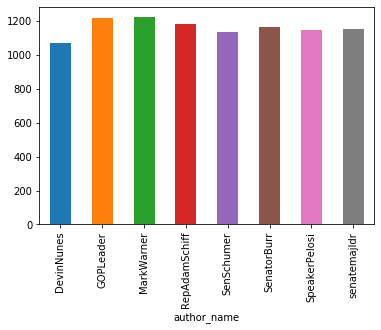

In [29]:
df.groupby(['author_name']).size().plot.bar()

### Constructing our target variable

Since we can determine the political affiliation of each of our 8 politicians, it's a simple thing to construct the target variable "Democrat" - which will hold one of two values, True or False.  We can also see, by the bar plot below, that we have balanced classes, so, there is no need to resample our data.

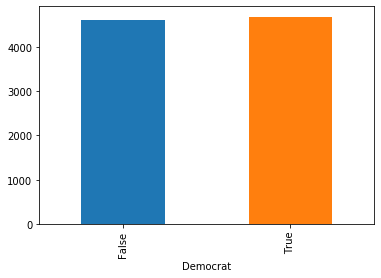

In [30]:
df["Democrat"] = df["author_name"].apply(is_democrat)
df.groupby(['Democrat']).size().plot.bar()

### Vectorize our Clean Tweets using Bag-Of-Words Model

Before we will train our first ML model using a RandomForestClassifier, we will vectorize our clean_tweets using sklearn's CountVectorizer, which will convert a collection of text documents into a matrix of token counts, where each single word is a token. This 'Bag-of-words' representation of our tweets will be used as the feature set for our first ML model. 

A brief explanation of the selected parameters and corresponding values that we will use to create the vectorizer, is as follows;
1. <b>max_features</b>: This specifies the number of top (in terms of overall term frequency) features used. After initially setting this to None so that we can determine how many features we actually have in our Corpus, we can then adjust this to a value that makes sense. For 16000 tweets, this number is around 4264. We will try a couple different values to see which gives us the best model performance.


2. <b>min_df</b> and <b>max_df</b>: These allow us to tell the vectorizer to ignore terms with frequencies that are lower or higher than specified cut-off values. A min_df of 5 instructs the vectorizer to ignore particularly rare terms, those that appear in less than 5 documents (tweets). A max_df of .7 instructs the vectorizer to ignore common terms, those that appear in more than 70% of documents (tweets).


3. <b>ngram_range</b>: This parameter allows us to specify the kind of n-gram that should be used in the vectorization process. This tuple specifies the lower and upper boundary of the n-gram range. A value of (1,1) just means that each token is a single word, or unigram. A value of (1,2) or (1,3) indicates that bigrams or trigrams should be used instead.


4. <b>stop_words</b>: This allows one to specify if stop_words should be removed from the text during the vectorization process, and if so, what language to use. Instead of removing stop_words in our CleanTweets function (which is common to do during pre-processing) I am opting to perform this during the vectorization process so that I can compare the difference between removing these stop words or not. For unigrams, it always makes sense to remove stop words, but for bigrams and trigrams, it's not as clear cut. It will be interesting to see the effect this has on overall model performance. 

In [49]:
# Create a BOW Vectorizer, transform the data and specify what our target variable is
df = df[pd.notnull(df['clean_tweet'])] 
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,1), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.clean_tweet).toarray()
y = df.Democrat

### Split the Data and Train the Model 

We will split our newly vectorized data into 80% train and 20% test. Our random state value will ensure that the data is split the same way each time so that we can replicate results. 

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [54]:
# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable
rfc_bow_unigram=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))   
best_so_far=rfc_bow_unigram

Confusion Matrix
[[731 195]
 [133 801]]
              precision    recall  f1-score   support

       False       0.85      0.79      0.82       926
        True       0.80      0.86      0.83       934

   micro avg       0.82      0.82      0.82      1860
   macro avg       0.83      0.82      0.82      1860
weighted avg       0.83      0.82      0.82      1860

AUC Score
0.9083293250886825
Accuracy Score
0.8236559139784946


### Analyze the Results for the Bag-Of-Words Model

Since an accuracy score alone is not always the best metric to look at in isolation, we also look at the confusion matrix, along with the AUC (Area Under the ROC Curve), precision, recall and f1-scores. This gives us a broader picture of the performance of the model. We will use both accuracy and AUC to compare model performance.  

In terms of this model, using a simple bag-of-words representation with single word tokens, we seem to have achieved an overall accuracy rate of about 82% to 84%. Which means that about 83% of the time, our Random Forest Classifier would correctly predict that a tweet was coming from a democrat or republican.

### Word Frequencies with TfidfVectorizer

An alternative to the Bag-Of-Words model is TF-IDF, or Term Frequency-Inverse Document Frequency. Instead of just counting the number of times a token appears in a document (tweet) we can use a different metric that takes into consideration the term frequency in relation to not only the current document, but also how often the term appears in all documents (corpus). TF-IDF are word frequency scores that try to highlight words that are more interesting. 

We will build a model using this alternative vectorizer, keeping all other parameters the same, and compare the results to the Bag-Of-Words model. 

In [55]:
# Create a tfidf Vectorizer and transform the data
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1, 1), stop_words=stopwords.words('english'))
X  = tfidfconverter.fit_transform(df.clean_tweet).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable
rfc_tfidf_unigram=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))  

if rfc_tfidf_unigram>best_so_far:
    best_so_far=rfc_tfidf_unigram

Confusion Matrix
[[729 197]
 [141 793]]
              precision    recall  f1-score   support

       False       0.84      0.79      0.81       926
        True       0.80      0.85      0.82       934

   micro avg       0.82      0.82      0.82      1860
   macro avg       0.82      0.82      0.82      1860
weighted avg       0.82      0.82      0.82      1860

AUC Score
0.9091485100892143
Accuracy Score
0.8182795698924731


### Analyze the Results for the TfidfVectorizer Model

Changing to a TF-IDF representation with single word tokens surprisingly decreased the overall accuracy rate just a little bit.  Because of this decrease in performance, we will switch back to using the BoW model to compare single word tokens to bigrams and trigrams. 

### Introducing bigrams and trigrams

#### Bigrams with stop words removed

Next, we change the ngram_range parameter of our TfidfVectorizer so that we can include bigrams or trigrams in our vector feature set. For each new model, we will compare the difference between including or not including stop words. 

This first one does have <b>stop words removed</b> during the vectorization process.


In [56]:
# Create a BoW Vectorizer using bigrams (without stopwords) and transform the data 
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,2), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.clean_tweet).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable 
rfc_bow_bigram=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))  
if rfc_bow_bigram>best_so_far:
    best_so_far=rfc_bow_bigram

Confusion Matrix
[[737 189]
 [128 806]]
              precision    recall  f1-score   support

       False       0.85      0.80      0.82       926
        True       0.81      0.86      0.84       934

   micro avg       0.83      0.83      0.83      1860
   macro avg       0.83      0.83      0.83      1860
weighted avg       0.83      0.83      0.83      1860

AUC Score
0.9105527446455246
Accuracy Score
0.8295698924731183


We can see that using bigram tokens instead of single word tokens did not necessarily change the accuracy much.

#### Bigrams with stop words <u>NOT</u> removed

This second one  <b>does <u>not</u> have stop words removed</b> during the vectorization process.

In [57]:
# Create a BoW Vectorizer using bigrams and transform the data 
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,2), stop_words=None)
X = vectorizer.fit_transform(df.clean_tweet).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable
rfc_bow_bigram_all_words=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))  

if rfc_bow_bigram_all_words>best_so_far:
    best_so_far=rfc_bow_bigram_all_words

Confusion Matrix
[[745 181]
 [122 812]]
              precision    recall  f1-score   support

       False       0.86      0.80      0.83       926
        True       0.82      0.87      0.84       934

   micro avg       0.84      0.84      0.84      1860
   macro avg       0.84      0.84      0.84      1860
weighted avg       0.84      0.84      0.84      1860

AUC Score
0.9112869471512943
Accuracy Score
0.8370967741935483


#### Trigrams with stop words removed

Next, we will try <b>trigrams</b> with stop words removed.

In [58]:
# Create a BoW Vectorizer using trigrams  (without stopwords)  and transform the data 
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,3), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.clean_tweet).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable
rfc_bow_trigram=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))  

if rfc_bow_trigram>best_so_far:
    best_so_far=rfc_bow_trigram

Confusion Matrix
[[737 189]
 [127 807]]
              precision    recall  f1-score   support

       False       0.85      0.80      0.82       926
        True       0.81      0.86      0.84       934

   micro avg       0.83      0.83      0.83      1860
   macro avg       0.83      0.83      0.83      1860
weighted avg       0.83      0.83      0.83      1860

AUC Score
0.9098312606083591
Accuracy Score
0.8301075268817204


#### Trigrams with stop words <u>NOT</u> removed

And finally, we try <b>trigrams</b> without removing stop words.

In [59]:
# Create a BoW Vectorizer using trigrams   and transform the data 
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,3), stop_words=None)
X = vectorizer.fit_transform(df.clean_tweet).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Random Forest Classifier, display the performance metrics and save accuracy score in a variable
rfc_bow_trigram_all_words=fit_predict_evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=1000, random_state=0))  

if rfc_bow_trigram_all_words>best_so_far:
    best_so_far=rfc_bow_trigram_all_words

Confusion Matrix
[[741 185]
 [123 811]]
              precision    recall  f1-score   support

       False       0.86      0.80      0.83       926
        True       0.81      0.87      0.84       934

   micro avg       0.83      0.83      0.83      1860
   macro avg       0.84      0.83      0.83      1860
weighted avg       0.84      0.83      0.83      1860

AUC Score
0.9110834516536321
Accuracy Score
0.8344086021505376


### Build a Variety of Classification Models

So far, we have had the best results with a BoW model, using bigrams tokens and <b><u>NOT</u></b> having stop words removed. Next, we will try out a few different machine learning algorithms to see if we can achieve better results. First, we will save our random forest classifier accuracy to a dictionary so that we can compare with other models. 

Please Note: The following ML models were built using different parameters for the vectorizer. The combination that provided the highest accuracy were kept.

In [60]:
ml_results={}
ml_results["RFC"]=best_so_far

In [101]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7,ngram_range=(1,3), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.clean_tweet).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Train a Naive Bayes model, display the performance metrics and save accuracy score in our dictionary object
ml_results["NB"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, MultinomialNB()) 

Confusion Matrix
[[744 182]
 [160 774]]
              precision    recall  f1-score   support

       False       0.82      0.80      0.81       926
        True       0.81      0.83      0.82       934

   micro avg       0.82      0.82      0.82      1860
   macro avg       0.82      0.82      0.82      1860
weighted avg       0.82      0.82      0.82      1860

AUC Score
0.9013977596995666
Accuracy Score
0.8161290322580645


In [87]:
from sklearn.linear_model import SGDClassifier
ml_results["SGD"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, SGDClassifier(loss='log', penalty='l1',alpha=1e-3, random_state=42, max_iter=15, tol=1e-3))

Confusion Matrix
[[795 131]
 [258 676]]
              precision    recall  f1-score   support

       False       0.75      0.86      0.80       926
        True       0.84      0.72      0.78       934

   micro avg       0.79      0.79      0.79      1860
   macro avg       0.80      0.79      0.79      1860
weighted avg       0.80      0.79      0.79      1860

AUC Score
0.8828467170163858
Accuracy Score
0.7908602150537635


In [103]:
from sklearn.linear_model import LogisticRegression
ml_results["LG"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs',max_iter=5000)) 

Confusion Matrix
[[674 252]
 [206 728]]
              precision    recall  f1-score   support

       False       0.77      0.73      0.75       926
        True       0.74      0.78      0.76       934

   micro avg       0.75      0.75      0.75      1860
   macro avg       0.75      0.75      0.75      1860
weighted avg       0.75      0.75      0.75      1860

AUC Score
0.7957674092710699
Accuracy Score
0.7537634408602151


In [66]:
from sklearn import svm
ml_results["SVC"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, svm.SVC(gamma='scale', kernel='rbf', C=.9, probability=True)) 

Confusion Matrix
[[787 139]
 [153 781]]
              precision    recall  f1-score   support

       False       0.84      0.85      0.84       926
        True       0.85      0.84      0.84       934

   micro avg       0.84      0.84      0.84      1860
   macro avg       0.84      0.84      0.84      1860
weighted avg       0.84      0.84      0.84      1860

AUC Score
0.9192527552827894
Accuracy Score
0.843010752688172


In [117]:
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=1000
)
ml_results["AB"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, classifier) 

Confusion Matrix
[[765 161]
 [170 764]]
              precision    recall  f1-score   support

       False       0.82      0.83      0.82       926
        True       0.83      0.82      0.82       934

   micro avg       0.82      0.82      0.82      1860
   macro avg       0.82      0.82      0.82      1860
weighted avg       0.82      0.82      0.82      1860

AUC Score
0.8974157228021331
Accuracy Score
0.8220430107526882


In [128]:
from xgboost.sklearn import XGBClassifier

classifier = XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=1000, objective='binary:logistic',random_state=123,n_jobs=4)
ml_results["XGB"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, classifier) 

Confusion Matrix
[[790 136]
 [159 775]]
              precision    recall  f1-score   support

       False       0.83      0.85      0.84       926
        True       0.85      0.83      0.84       934

   micro avg       0.84      0.84      0.84      1860
   macro avg       0.84      0.84      0.84      1860
weighted avg       0.84      0.84      0.84      1860

AUC Score
0.9255981148917081
Accuracy Score
0.8413978494623656


### Compare Results of ML models using BoW with trigrams

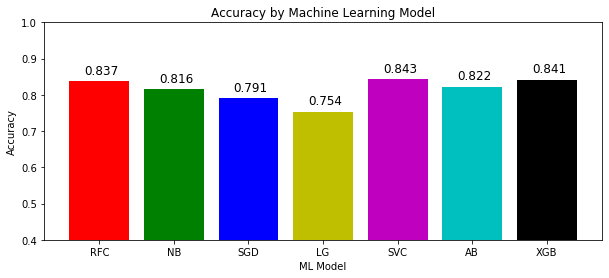

In [131]:
my_colors = 'rgbymck'
f, ax = plt.subplots(figsize=(10,4))
plt.bar(range(len(ml_results)), list(ml_results.values()), align='center', width = .8, color=my_colors)
plt.ylim(.4, 1)
plt.ylabel('Accuracy')
plt.xlabel('ML Model')
plt.title('Accuracy by Machine Learning Model')
plt.xticks(range(len(ml_results)), list(ml_results.keys()))

x_val=-.2
for value in ml_results.values():
    plt.text(x = x_val , y = value+.02, s = str(round(value, 3)) , size = 12)
    x_val=x_val+1
#plt.text(x=)
plt.show()

### ML Winner

####  Depending on the specific group of tweets used to train the various models, XGBoost and SVC generally seem to perform better than the other models, but this was done before performing any kind of  hyperparameter optimization.

Just for fun, let's go ahead and use a Grid Search on one or more of these models, to see if hyperparameter tuning can make  much difference? For example, can we improve the SGD classifier to be better than the best accuracy so far? 

####  SGDClassifier model with GridSearchCV  

PLEASE NOTE: IDEALLY WE WOULD DO GRID SEARCH AND HYPERPARAMETER TUNING ON ALL ML MODELS BEFORE SELECTING THE 'BEST' LEARNER, BUT GIVEN THE FACT THAT THIS IS A LEARNING PROJECT, AND BUILDING A MODEL WITH GRID SEARCH TAKES A LONG TIME, I AM LIMITING MYSELF TO JUST ONE EXAMPLE, SHOWN BELOW:

In [95]:
from sklearn.model_selection import GridSearchCV
sgd = SGDClassifier( random_state=42, max_iter=1000, tol=1e-3)

param_grid = {
    'loss': ['log'],
    'penalty': ['l2','l1','none'],
    'alpha':  [ 0.001, 0.01, 0.1],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5],
}

ml_results["SGD_optimized"]=fit_predict_evaluate(X_train, X_test, y_train, y_test, GridSearchCV(sgd, param_grid, scoring = 'accuracy', cv=5)) 



Confusion Matrix
[[806 120]
 [174 760]]
              precision    recall  f1-score   support

       False       0.82      0.87      0.85       926
        True       0.86      0.81      0.84       934

   micro avg       0.84      0.84      0.84      1860
   macro avg       0.84      0.84      0.84      1860
weighted avg       0.84      0.84      0.84      1860

AUC Score
0.9227948487889706
Accuracy Score
0.8419354838709677


Again, based on the underlying data, we were able to improve upon our accuracy rate by 0-4 percentage points. Next, we will try our luck with a neural network model using keras.

### Neural Network using a Sequential Keras Model

The first NN model we train will use our existing BoW representation of our tweet text. Our X and y variables can be used, unchanged, in training this sequential model with two dense layers. After running the following code several times and using the graphs of the history (which show accuracy and loss for train/test at each epoch) to the learning progress, I have settled on 3 epochs to minimize overfitting.

In [69]:
epochs = 3
batch_size = 16
input_size=2000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

if len(X_train[1])<input_size:
    input_size=len(X_train[1])

model = Sequential()
model.add(layers.Dense(10, input_dim=input_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    
history = model.fit(X_train, y_train,
                     epochs=epochs,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=batch_size)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1860/1860 [==============================] - ETA: 0s - loss: 0.2460 - acc: 0.937 - ETA: 0s - loss: 0.3358 - acc: 0.851 - 0s 35us/sample - loss: 0.3374 - acc: 0.8516


### Plotting the history allows us to decide on number of epochs

Neural networks differ from traditional machine learning models in that we must specify how long they train for. This is specified by the number of epochs. One epoch is one forward pass and one backward pass of all training examples. The more epochs we use in training, the more the model fits to the training data. Choosing number of epochs is important and made easier by visualizing accuracy and loss for training/testing data at each epoch. The idea is that we want to use just enough epochs to train without overfitting. 

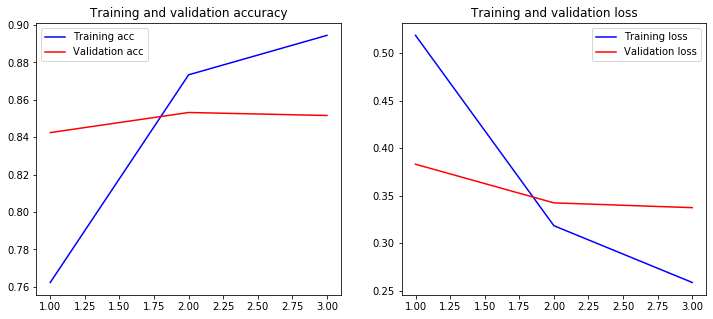

In [70]:
plot_history(history)

In [71]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
ml_results["ANN_BOW"]=score[1]

Test loss: 0.3373899399593312
Test accuracy: 0.8516129


### Slight improvement detected over most of our traditional ML models

Our accuracy on test data using a sequential neural network model with two dense layers, run for just 3 epohcs, shows it performed slightly better than the traditional machine learning models.

### Word Embeddings vs. BoW

Next, we will look to see if using word embeddings (dense word vectors) instead of BoW vectors can improve importance. The motivation to switching to word embeddings is because word embeddings can capture relationships between words in a way that BoW cannot. It is not clear if political affiliation classification can be improved when switching to this type of word vectorization. Generally, switching to embedding will improve a model, but BoW is sometimes more effective if the dataset is small and content is domain specific. 

We will try two different types of word embeddings, those that are learned based on our tweet corpus, and those that are pre-trained (GloVe/word2vec). We will also train a couple different types of Neural Networks, a simple feed forward Neural Network and a Recurrent Neural Network. Adding an LSTM (Long Short Term Memory) layer may be able to take advantage of text representation that preserves order, which is one of the benefits of word embeddings over bag-of-word vectors. 

We will not use our old X, y data, since that has been tokenized into bigrams. Instead, we will retokenize our data (after removing stop words) using our saved clean_tweet data.

### Stop words - Include or Remove?

Again, we will build models both ways, with stop words in and stop words removed

In [73]:
# Since our clean_tweet function does not remove stop words, let's remove them now with our remove_stop_words function
remove_stop_words_for_embeddings = True
df = df[pd.notnull(df['clean_tweet'])]    
if remove_stop_words_for_embeddings:
    tweets = df["clean_tweet"].apply(remove_stop_words).values
else:
    tweets =  df.clean_tweet.values

In [74]:
y = df.Democrat
tweets_train, tweets_test, y_train, y_test = train_test_split(tweets, y,  test_size=0.2, random_state=22)

# Tokenize the entire data using Tokenizer object from keras
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

# Need to add one to take into consideration a zero based index
vocab_size = len(tokenizer.word_index) + 1

max_tweet_length = 280

# Add padding to the sequences to make them of a uniform length
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_tweet_length)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_tweet_length)

### Switch from BoW to Word Embedding

Now that we have re-tokenized our tweets using keras, calculated the size of our corpus, and padded our sequences so that they are all the same time, we are ready to build and train our NN with a different representation of our tweet data. The Embedding layer takes the previously calculated integers and maps them to a dense vector of the embedding, which is learned during the training of the model.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 32)           312448    
_________________________________________________________________
flatten (Flatten)            (None, 8960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                89610     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 402,069
Trainable params: 402,069
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9883
Testing Accuracy:  0.8204


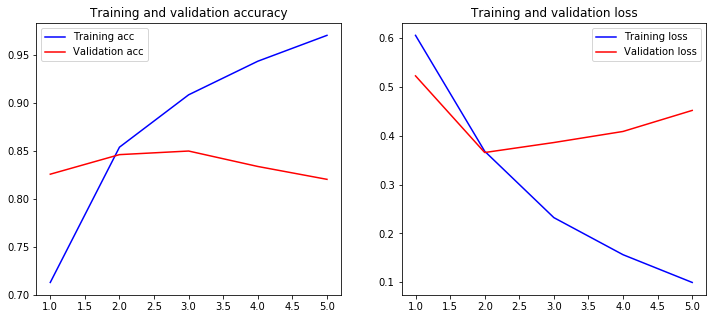

In [75]:
num_neurons=10
embedding_vecor_length = 32
batch_size=16
epochs=5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vecor_length, input_length=max_tweet_length))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=False,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
ml_results["ANN_EMB"]=accuracy

Unfortunately, our accuracy didn't improve. But not all is lost. Maybe our model will perform better if it is a recurrent neural network.

### Ready for an RNN model using LSTM architecture 

Next, we build and train an RNN with the addition of an LSTM layer. The Embedding layer feeds our vectorized data to LSTM layer, which has the added benefit of being able to take the sequence of words into consideration when building the model. It's unclear if this will help in our use case.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 32)           312448    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                1720      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 314,289
Trainable params: 314,289
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9421
Testing Accuracy:  0.8333


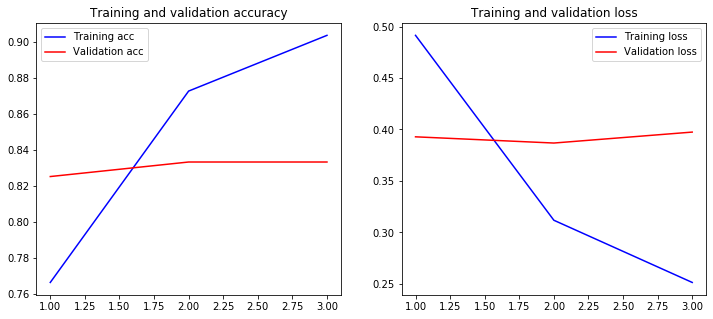

In [76]:
num_neurons=10
embedding_vecor_length = 32
batch_size=16
epochs=5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vecor_length, input_length=max_tweet_length))
model.add(LSTM(num_neurons))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=False,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
ml_results["RNN_EMB"]=accuracy
plot_history(history)



### Will adding a dropout layer improve the model?

The motivation behind adding a dropout layer is to help prevent overfitting. If we can decrease overfitting, maybe we can train for more epochs?

Training Accuracy: 0.9642
Testing Accuracy:  0.8199


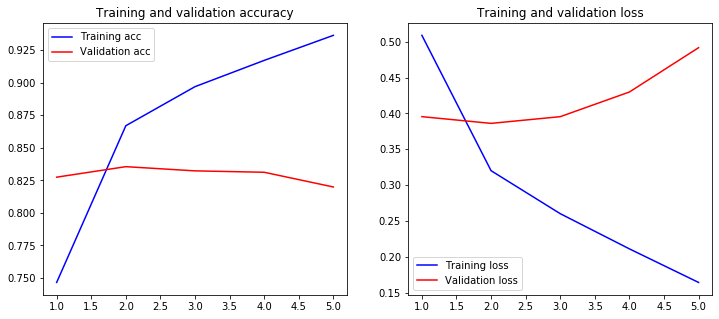

In [77]:
num_neurons=10
embedding_vecor_length = 32
dropout_pcnt=.2
batch_size=16
epochs=5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vecor_length, input_length=max_tweet_length))
model.add(LSTM(num_neurons))
model.add(Dropout(dropout_pcnt))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=False,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
ml_results["RNN_DROP"]=accuracy
plot_history(history)

Accuracy didn't improve and the visualizations show that our rate of learning has not changed much. Perhaps this technique would make more sense with a larger dataset.  

### Using Pretrained Word Embeddings with LSTM

Finally, we will try one last NLP technique. Instead of training our own word embeddings, we will use one that has been pre-trained. The following code uses GloVe (another option would be Word2Vec) with the parameter 'trainable' set to true, which means the embedding will be updated during training. I tried this parameter both ways and found that setting this to true produced better results. Because we are using a dropout layer, overfitting is slightly less of an issue, which lets us train for more epochs than the previous models.

In [78]:
embedding_vecor_length=32
emb_matrix = create_emb_matrix('data/glove.6B.200d.txt',tokenizer.word_index, embedding_vecor_length)

Training Accuracy: 0.9239
Testing Accuracy:  0.8306


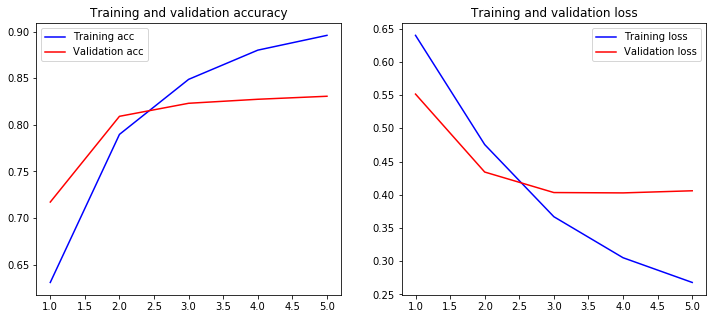

In [79]:
num_neurons=10
dropout_pcnt=.2
batch_size=16
epochs=5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vecor_length, weights=[emb_matrix], input_length=max_tweet_length, trainable=True))
         
model.add(LSTM(num_neurons))
model.add(Dropout(dropout_pcnt))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
ml_results["RNN_GLOVE"]=accuracy
plot_history(history)

### Convolutional Neural Network (CNN)

Next, we will try a CNN model to see how that compares to our RNN. Since we are working with text data (which is 1 dimensional sequence) instead of image data (which is 2 dimensional), we will use just one dimension for our convolution and max pooling layers. I ran the following code using 2, 3, and 4 for our kernel size (size of the convolutional window) and found that a value of 3 produced the best result. I stuck with the default stride size of 1.  

Training Accuracy: 0.9718
Testing Accuracy:  0.8210


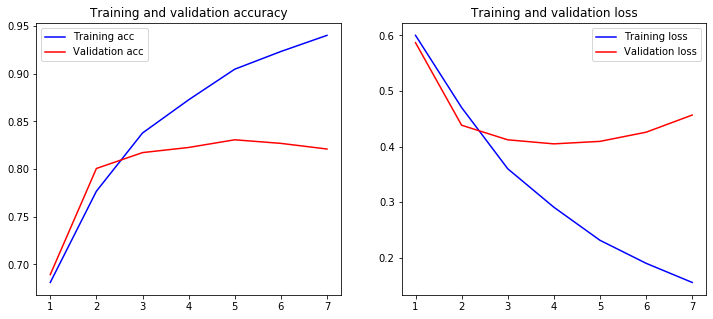

In [80]:
num_neurons=10
dropout_pcnt=.2
batch_size=16
epochs=7
embedding_vecor_length=32 # or embedding dimension
max_tweet_length = 280
kernel =3  
    
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vecor_length, weights=[emb_matrix], input_length=max_tweet_length, trainable=True))
model.add(Conv1D (filters=embedding_vecor_length,  kernel_size=kernel, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, padding='same'))
model.add(Flatten())
model.add(Dropout(dropout_pcnt))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
ml_results["CNN_GLOVE"]=accuracy
plot_history(history)

Although our CNN model didn't perform quite as good as our RNN, which leveraged Long Short Term Memory, the code certainly runs much faster. This is due to the way the convolutional layer and max pooling layers shrink the dimensions of the data before being fed to the dense layers of the network.

C:\Users\rebec\Anaconda3\envs\uwdatasci420\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


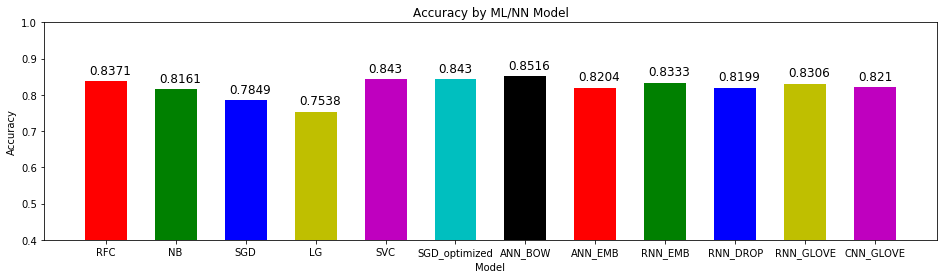

In [81]:
fig = plt.figure(figsize=(16,4)) # Define plot area
ax1 = fig.add_subplot(111)
my_colors = 'rgbymckrgbymck'

ax1.bar(ml_results.keys(), ml_results.values(), width = .6,color=my_colors)
ax1.set_xticks(range(len(ml_results)), list(ml_results.keys()))
plt.ylim(.4, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracy by ML/NN Model')

x_val=-.24
for value in ml_results.values():
    plt.text(x = x_val , y = value+.02, s = str(round(value, 4)) , size = 12)
    x_val=x_val+1
fig.show()

### Summary

By keeping our dataset fairly small, to only about 8000 tweets, we were able to exercise many NLP techniques in a timely manner. 

After using our custom made twitter objects to pull data from the Tweepy API, and manually preprocessing the text, we were able to push this data through several machine learning models to perform supervised learning for a binary classification problem. 

Most models performed fairly well, within a 75% – 85% accuracy rate, when used to predict the political affiliation of the politicians behind the tweets. Although the Random Forest Classifier and SVC models performed almost as well as our neural networks, I suspect that as the size of our dataset increased, our neural networks would improve faster than the more traditional machine learning models, since their strength is more apparent when dealing with big data. 

The interesting question is, would CNNs or RNNs eventually win out as the stronger model as the size of the dataset increased? When working with word embeddings, as opposed to BOW or TF-IDF, additional complexity is available to the neural networks. Instead of just occurrence or frequency of words, these word vectors preserve the order that the words, as well as a form of semantic meaning for each word. Both CNN and RNN models can take advantage of this more complex representation of text, but in different ways. Recurrent Neural Networks, which are designed to make use of sequential data, are able to utilize the order of words to build a more complex model, whereas Convolutional Neural Networks are able to use convolutions and pooling operations to recognize patterns in embedding word vectors that would not be possible for simple BOW representations.

Much thanks to the following articles that helped me clean up my code and better explain many of the NLP techniques used in this project:

<a href="https://kavita-ganesan.com/text-preprocessing-tutorial/?relatedposts_hit=1&relatedposts_origin=1659&relatedposts_position=1#.XbdeQJpKiUk">All you need to know about Text Preprocessing for Machine Learning & NLP</a> By Kavita Ganesan
    
<a href="https://realpython.com/python-keras-text-classification/">Practical Text Classification With Python and Keras</a>, by by Nikolai Janakiev

<a href="https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#targetText=Keras%20Embedding%20Layer,represented%20by%20a%20unique%20integer">How to Use Word Embedding Layers for Deep Learning with Keras</a>, by Jason Brownlee

<a href="https://towardsdatascience.com/text-classification-rnns-or-cnn-s-98c86a0dd361">Text Classification — RNN’s or CNN’s?</a> by Shreya Ghelani

<a href="http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/">Understanding Convolutions in Text</a> by Debajyoti Datta

<a href="https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/">Keras Conv1D: Working with 1D Convolutional Neural Networks in Keras</a> by missinglink.ai

<a href="https://www.youtube.com/channel/UCFxcvyt2Ucq5IL0_1Njzqlg">Various videos put togeather</a> by LucidProgramming